<a href="https://colab.research.google.com/github/davidwhogg/EmuCosmoSim/blob/main/ipynb/group_averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding equivariant convolution operators by group averaging

## Authors:
- **David W. Hogg** (NYU) (Flatiron)
- **Soledad Villar** (JHU)

## License
Copyright 2022 the authors. All rights reserved *for now*.

## To-do
- Do the 2-tensor filters! Do we want to separate Hermitian and anti-Hermitian cases? Probably?
- Make structure so the code is agnostic about scalar/vector/tensor? That is, such that the objects know their own transformation properties?

## Bugs:
- This code transmits `D, M, pixels, keys` as global variables, not by reading them off inputs (or getting them as inputs).
- The group operators should be found by recursion; this ought to be more efficient.
- Fix 3-d plotting so it does a real projection (not just a set of incomprehensible hacks).

In [1]:
import numpy as np
import pylab as plt
import itertools as it
import scipy.signal as sig

In [2]:
# Set integers:
D = 2 # D-dimensional image (must be 2 or 3 for plotting to work)
M = 5 # must be an odd integer

In [3]:
# Make all n x n pixels
if M % 2 != 1:
    print("Filter size must be odd")
    assert False
foo = range(-((M - 1) // 2), ((M + 1) // 2))
pixels = np.array([pp for pp in it.product(foo, repeat=D)]).astype(int)

In [4]:
# Define hash and unhash functions for pixel names
def hash(pp):
    return str(pp.astype(int))[1:-1]

def unhash(kk):
    return np.fromstring(kk, sep=" ").astype(int)

In [5]:
# Make all keys
keys = [hash(pp) for pp in pixels]
print(keys)

['-2 -2', '-2 -1', '-2  0', '-2  1', '-2  2', '-1 -2', '-1 -1', '-1  0', '-1  1', '-1  2', ' 0 -2', ' 0 -1', '0 0', '0 1', '0 2', ' 1 -2', ' 1 -1', '1 0', '1 1', '1 2', ' 2 -2', ' 2 -1', '2 0', '2 1', '2 2']


In [6]:
# Make all possible group generators

# Make the flip operator
foo = np.ones(D).astype(int)
foo[0] = -1
gg = np.diag(foo).astype(int)
generators = [gg, ]

# Make the 90-degree rotation operators
for i in range(D):
    for j in range(i + 1, D):
        gg = np.eye(D).astype(int)
        gg[i, i] = 0
        gg[j, j] = 0
        gg[i, j] = -1
        gg[j, i] = 1
        generators.append(gg)
generators = np.array(generators)

# Look at them
for gg in generators:
    print(gg)

[[-1  0]
 [ 0  1]]
[[ 0 -1]
 [ 1  0]]


In [7]:
# Make all possible group operators.
# This code is very wasteful; there is a better way with recursion.

def make_all_operators(generators):
    operators = np.array([np.eye(D).astype(int), ])
    foo = 0
    while len(operators) != foo:
        foo = len(operators)
        operators = make_new_operators(operators, generators)
    return(operators)

def make_new_operators(operators, generators):
    for op in operators:
        for gg in generators:
            op2 = (gg @ op).astype(int)
            operators = np.unique(np.append(operators, op2[None, :, :], axis=0), axis=0)
    return operators

group_operators = make_all_operators(generators)
print("I found", len(group_operators), "group operators; here are their determinants:")
for gg in group_operators:
    print(gg, "determinant:", np.linalg.slogdet(gg)[0].astype(int))

I found 8 group operators; here are their determinants:
[[-1  0]
 [ 0 -1]] determinant: 1
[[-1  0]
 [ 0  1]] determinant: -1
[[ 0 -1]
 [-1  0]] determinant: -1
[[ 0 -1]
 [ 1  0]] determinant: 1
[[ 0  1]
 [-1  0]] determinant: 1
[[0 1]
 [1 0]] determinant: -1
[[ 1  0]
 [ 0 -1]] determinant: -1
[[1 0]
 [0 1]] determinant: 1


In [8]:
# Check that each group operator leaves the pixel list unchanged
for gg in group_operators:
    newpixels = np.array([gg @ pp.copy() for pp in pixels]).astype(int)
    assert(set(tuple(pp) for pp in newpixels) == set(tuple(pp) for pp in pixels))
    print(gg, True)

[[-1  0]
 [ 0 -1]] True
[[-1  0]
 [ 0  1]] True
[[ 0 -1]
 [-1  0]] True
[[ 0 -1]
 [ 1  0]] True
[[ 0  1]
 [-1  0]] True
[[0 1]
 [1 0]] True
[[ 1  0]
 [ 0 -1]] True
[[1 0]
 [0 1]] True


In [9]:
# Check that the list of group operators is closed
for gg in group_operators:
    for gg2 in group_operators:
        assert ((gg @ gg2).astype(int) in group_operators)
    print(gg, True)

[[-1  0]
 [ 0 -1]] True
[[-1  0]
 [ 0  1]] True
[[ 0 -1]
 [-1  0]] True
[[ 0 -1]
 [ 1  0]] True
[[ 0  1]
 [-1  0]] True
[[0 1]
 [1 0]] True
[[ 1  0]
 [ 0 -1]] True
[[1 0]
 [0 1]] True


In [10]:
# Check that gg.T is gg.inv for all gg in group?
for gg in group_operators:
    print(gg, np.allclose(gg @ gg.T, np.eye(D)))

[[-1  0]
 [ 0 -1]] True
[[-1  0]
 [ 0  1]] True
[[ 0 -1]
 [-1  0]] True
[[ 0 -1]
 [ 1  0]] True
[[ 0  1]
 [-1  0]] True
[[0 1]
 [1 0]] True
[[ 1  0]
 [ 0 -1]] True
[[1 0]
 [0 1]] True


In [11]:
# Make filter manipulation functions

def rotate_scalar(filter, gg):
    newfilter = filter.copy()
    for kk in keys:
        newfilter[hash(gg @ unhash(kk))] = filter[kk]
    return newfilter

def rotate_pseudoscalar(filter, gg):
    newfilter = filter.copy()
    for kk in keys:
        newfilter[hash(gg @ unhash(kk))] = (np.linalg.slogdet(gg)[0] * filter[kk]).astype(int)
    return newfilter

def rotate_vector(filter, gg):
    newfilter = filter.copy()
    for kk in keys:
        newfilter[hash(gg @ unhash(kk))] = (gg @ filter[kk]).astype(int)
    return newfilter

def rotate_pseudovector(filter, gg):
    newfilter = filter.copy()
    for kk in keys:
        newfilter[hash(gg @ unhash(kk))] = (np.linalg.slogdet(gg)[0] * gg @ filter[kk]).astype(int)
    return newfilter

def add(filter1, filter2):
    newfilter = filter1.copy()
    for kk in keys:
        newfilter[kk] = filter1[kk] + filter2[kk]
    return newfilter

def pack_scalar_filter(amps):
    assert len(amps) == M ** D
    return {kk: ff for kk, ff in zip(keys, amps)}

def unpack_scalar_filter(filter):
    return np.array([filter[kk] for kk in keys])

def make_zero_scalar_filter():
    return pack_scalar_filter(np.zeros(M ** D).astype(int))

def pack_vector_filter(vecs):
    assert len(vecs) == M ** D
    return {kk: ff for kk, ff in zip(keys, vecs)}

def unpack_vector_filter(filter):
    return np.array([filter[kk] for kk in keys])

def make_zero_vector_filter():
    return pack_vector_filter(np.zeros((M ** D, D)).astype(int))

In [12]:
# Make nxn independent scalar-to-scalar filters
allfilters = []
for kk in keys:
    thisfilter = make_zero_scalar_filter()
    thisfilter[kk] = 1
    allfilters.append(thisfilter)

In [13]:
# Sum all the group-element-transformed scalar-to-scalar filters and make a matrix of them
n = len(allfilters)
filter_matrix = np.zeros((n, n)).astype(int)
for i, f1 in enumerate(allfilters):
    ff = make_zero_scalar_filter()
    for gg in group_operators:
        ff = add(ff, rotate_scalar(f1, gg))
    filter_matrix[i] = unpack_scalar_filter(ff)

In [14]:
# What are the unique scalar-to-scalar filters?
def get_unique_scalar_filters(matrix):
    u, s, v = np.linalg.svd(matrix)
    TINY = 1.e-5
    sbig = s > TINY
    if not np.any(sbig):
        return []
    # normalize the ampltidues so they max out at +/- 1.
    amps = v[sbig] / np.max(np.abs(v[sbig]), axis=1)[:, None]
    # make sure the amps are positive, generally
    for i in range(len(amps)):
        if np.sum(amps[i]) < 0:
            amps[i] *= -1
    # make sure that the zeros are zeros.
    amps[np.abs(amps) < TINY] = 0.
    return order_filters([pack_scalar_filter(aa) for aa in amps])

def filter_size(filter):
    """
    What is the (squared) size of the filter footprint?
    """
    foo, bar = 0., 0.
    for kk, pp in zip(keys, pixels):
        foo += np.sum((pp * np.sqrt(np.sum(np.atleast_1d(filter[kk] ** 2)))) ** 2)
        bar += np.sum((np.sqrt(np.sum(np.atleast_1d(filter[kk] ** 2)))) ** 2)
    return foo / bar

def order_filters(filters):
    """
    Order filters by size.
    """
    sizes = [filter_size(ff) for ff in filters]
    return [filters[ii] for ii in np.argsort(sizes)]

filters = get_unique_scalar_filters(filter_matrix)
for ff in filters:
    print(ff)

{'-2 -2': 0.0, '-2 -1': 0.0, '-2  0': 0.0, '-2  1': 0.0, '-2  2': 0.0, '-1 -2': 0.0, '-1 -1': 0.0, '-1  0': 0.0, '-1  1': 0.0, '-1  2': 0.0, ' 0 -2': 0.0, ' 0 -1': 0.0, '0 0': 1.0, '0 1': 0.0, '0 2': 0.0, ' 1 -2': 0.0, ' 1 -1': 0.0, '1 0': 0.0, '1 1': 0.0, '1 2': 0.0, ' 2 -2': 0.0, ' 2 -1': 0.0, '2 0': 0.0, '2 1': 0.0, '2 2': 0.0}
{'-2 -2': 0.0, '-2 -1': 0.0, '-2  0': 0.0, '-2  1': 0.0, '-2  2': 0.0, '-1 -2': 0.0, '-1 -1': 0.0, '-1  0': 1.0, '-1  1': 0.0, '-1  2': 0.0, ' 0 -2': 0.0, ' 0 -1': 0.9999999999999998, '0 0': 0.0, '0 1': 0.9999999999999998, '0 2': 0.0, ' 1 -2': 0.0, ' 1 -1': 0.0, '1 0': 0.9999999999999998, '1 1': 0.0, '1 2': 0.0, ' 2 -2': 0.0, ' 2 -1': 0.0, '2 0': 0.0, '2 1': 0.0, '2 2': 0.0}
{'-2 -2': 0.0, '-2 -1': 0.0, '-2  0': 0.0, '-2  1': 0.0, '-2  2': 0.0, '-1 -2': 0.0, '-1 -1': 0.9999999999999998, '-1  0': 0.0, '-1  1': 1.0, '-1  2': 0.0, ' 0 -2': 0.0, ' 0 -1': 0.0, '0 0': 0.0, '0 1': 0.0, '0 2': 0.0, ' 1 -2': 0.0, ' 1 -1': 0.9999999999999998, '1 0': 0.0, '1 1': 0.99999

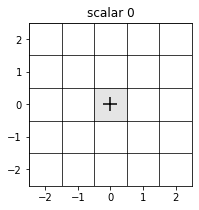

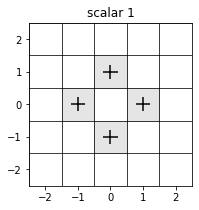

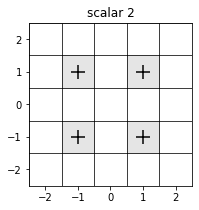

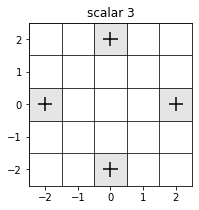

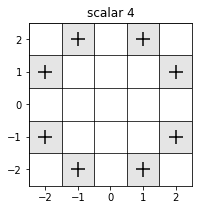

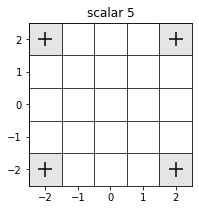

In [15]:
# Visualize (badly) the scalar filters.

FIGSIZE = (4, 3)
XOFF, YOFF = 0.15, -0.1
TINY = 1.e-5

def setup_plot():
    fig = plt.figure(figsize=FIGSIZE)

def finish_plot(title):
    plt.title(title)
    if D == 2:
        plt.xlim(np.min(pixels)-0.5, np.max(pixels)+0.5)
        plt.ylim(np.min(pixels)-0.5, np.max(pixels)+0.5)
    if D == 3:
        plt.xlim(np.min(pixels)-0.75, np.max(pixels)+0.75)
        plt.ylim(np.min(pixels)-0.75, np.max(pixels)+0.75)
    plt.gca().set_aspect("equal")

def plot_boxes(xs, ys):
    for x, y in zip(xs, ys):
        plt.plot([x-0.5, x-0.5, x+0.5, x+0.5, x-0.5],
                 [y-0.5, y+0.5, y+0.5, y-0.5, y-0.5], "k-", lw=0.5)

def fill_boxes(xs, ys, ws):
    for x, y, w in zip(xs, ys, ws):
        if np.abs(w) > TINY:
            plt.fill_between([x - 0.5, x + 0.5], [y - 0.5, y - 0.5], [y + 0.5, y + 0.5],
                             color="k", alpha=0.1)

def plot_scalars(xs, ys, ws):
    plot_boxes(xs, ys)
    fill_boxes(xs, ys, ws)
    plt.scatter(xs[ws > TINY], ys[ws > TINY], marker="+", c="k", s=(1000/M)*ws[ws > TINY])
    plt.scatter(xs[ws < TINY], ys[ws < TINY], marker="_", c="k", s=(-1000/M)*ws[ws < TINY])

def plot_scalar_filter(filter, title):
    if D not in [2, 3]:
        print("plot_scalar_filter(): Only works for D in [2, 3].")
        return
    setup_plot()
    xs, ys, zs = np.zeros(M ** D), np.zeros(M ** D), np.zeros(M ** D)
    ws = np.zeros(M ** D)
    if D == 2:
        for i, kk in enumerate(keys):
            xs[i], ys[i] = unhash(kk)
            ws[i] = filter[kk]
        plot_scalars(xs, ys, ws)
    if D == 3:
        for i, kk in enumerate(keys):
            xs[i], ys[i], zs[i] = unhash(kk)
            ws[i] = filter[kk]
        plot_scalars(xs + XOFF * zs, ys + YOFF * zs, ws)
    finish_plot(title)

for i, ff in enumerate(filters):
    plot_scalar_filter(ff, "scalar " + str(i))

In [16]:
# Sum all the group-element-tranformed scalar-to-pseudoscalar filters and make a matrix of them
n = len(allfilters)
pfilter_matrix = np.zeros((n, n)).astype(int)
for i, f1 in enumerate(allfilters):
    ff = make_zero_scalar_filter()
    for gg in group_operators:
        ff = add(ff, rotate_pseudoscalar(f1, gg))
    pfilter_matrix[i] = unpack_scalar_filter(ff)

In [17]:
# What are the unique scalar-to-scalar filters?
pfilters = get_unique_scalar_filters(pfilter_matrix)
for ff in pfilters:
    print(ff)

{'-2 -2': 0.0, '-2 -1': 0.9999999999999999, '-2  0': 0.0, '-2  1': -0.9999999999999997, '-2  2': 0.0, '-1 -2': -0.9999999999999997, '-1 -1': 0.0, '-1  0': 0.0, '-1  1': 0.0, '-1  2': 0.9999999999999997, ' 0 -2': 0.0, ' 0 -1': 0.0, '0 0': 0.0, '0 1': 0.0, '0 2': 0.0, ' 1 -2': 0.9999999999999997, ' 1 -1': 0.0, '1 0': 0.0, '1 1': 0.0, '1 2': -0.9999999999999997, ' 2 -2': 0.0, ' 2 -1': -0.9999999999999997, '2 0': 0.0, '2 1': 1.0, '2 2': 0.0}


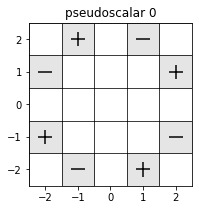

In [18]:
# Visualize (badly) the pseudoscalar filters.
for i, ff in enumerate(pfilters):
    plot_scalar_filter(ff, "pseudoscalar " + str(i))

In [19]:
# Make Dn x Dn x ... independent scalar-to-vector filters
allvfilters = []
for kk in keys:
    for i in range(D):
        thisfilter = make_zero_vector_filter()
        thisfilter[kk][i] = 1
        allvfilters.append(thisfilter)

In [20]:
# Sum all the group-element-tranformed scalar-to-vector filters and make a matrix of them
n = len(allvfilters)
vfilter_matrix = np.zeros((n, n)).astype(int)
for i, f1 in enumerate(allvfilters):
    ff = make_zero_vector_filter()
    for gg in group_operators:
        ff = add(ff, rotate_vector(f1, gg))
    vfilter_matrix[i] = unpack_vector_filter(ff).flatten()

In [21]:
# What are the unique scalar-to-vector filters?
def get_unique_vector_filters(matrix, parity):
    u, s, v = np.linalg.svd(matrix)
    TINY = 1.e-5
    sbig = s > TINY
    if not np.any(sbig):
        return []
    nbig = np.sum(sbig).astype(int)
    vecs = v[sbig].reshape((nbig, M ** D, D))
    # normalize so the vectors are (on average) unit vectors
    norms = np.sqrt(np.sum(vecs * vecs, axis=2))
    norms[norms < TINY] = 1.0
    vecs = vecs / norms[:, :, None]
    # make sure the divergences or curls are positive
    if parity > 0:
        for i in range(nbig):
            if np.sum(vecs[i] * pixels) < 0:
                vecs[i] *= -1
    if D == 2 and parity < 0:
        rpixels = np.zeros_like(pixels)
        rpixels[:, 0], rpixels[:, 1] = -1. * pixels[:, 1], pixels[:, 0]
        for i in range(nbig):
            if np.sum(vecs[i] * rpixels) < 0:
                vecs[i] *= -1
    # make sure zeros are exactly zero
    vecs[np.abs(vecs) < TINY] = 0.0
    return order_filters([pack_vector_filter(vv) for vv in vecs])

vfilters = get_unique_vector_filters(vfilter_matrix, 1)
for ff in vfilters:
    print(ff)

{'-2 -2': array([0., 0.]), '-2 -1': array([0., 0.]), '-2  0': array([0., 0.]), '-2  1': array([0., 0.]), '-2  2': array([0., 0.]), '-1 -2': array([0., 0.]), '-1 -1': array([0., 0.]), '-1  0': array([-1.,  0.]), '-1  1': array([0., 0.]), '-1  2': array([0., 0.]), ' 0 -2': array([0., 0.]), ' 0 -1': array([ 0., -1.]), '0 0': array([0., 0.]), '0 1': array([0., 1.]), '0 2': array([0., 0.]), ' 1 -2': array([0., 0.]), ' 1 -1': array([0., 0.]), '1 0': array([1., 0.]), '1 1': array([0., 0.]), '1 2': array([0., 0.]), ' 2 -2': array([0., 0.]), ' 2 -1': array([0., 0.]), '2 0': array([0., 0.]), '2 1': array([0., 0.]), '2 2': array([0., 0.])}
{'-2 -2': array([0., 0.]), '-2 -1': array([0., 0.]), '-2  0': array([0., 0.]), '-2  1': array([0., 0.]), '-2  2': array([0., 0.]), '-1 -2': array([0., 0.]), '-1 -1': array([-0.70710678, -0.70710678]), '-1  0': array([0., 0.]), '-1  1': array([-0.70710678,  0.70710678]), '-1  2': array([0., 0.]), ' 0 -2': array([0., 0.]), ' 0 -1': array([0., 0.]), '0 0': array([

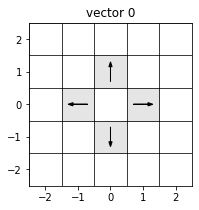

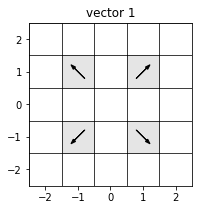

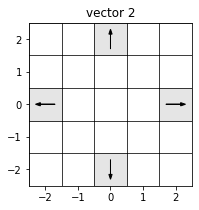

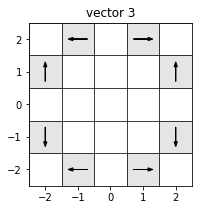

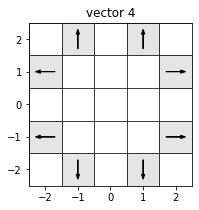

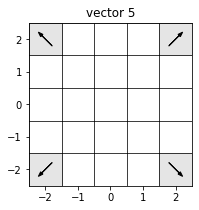

In [22]:
# Visualize the vector filters.

def plot_vectors(xs, ys, ws):
    plot_boxes(xs, ys)
    fill_boxes(xs, ys, np.sum(np.abs(ws), axis=-1))
    for x, y, w in zip(xs, ys, ws):
        if np.sum(w * w) > TINY:
            plt.arrow(x - 0.3 * w[0], y - 0.3 * w[1],
                      0.6 * w[0], 0.6 * w[1],
                      length_includes_head=True, head_width=0.1, color="k")

def plot_vector_filter(filter, title):
    if D not in [2, 3]:
        print("plot_vector_filter(): Only works for D in [2, 3].")
        return
    setup_plot()
    xs, ys, zs = np.zeros(M ** D), np.zeros(M ** D), np.zeros(M ** D)
    ws = np.zeros((M ** D, D))
    if D == 2:
        for i, kk in enumerate(keys):
            xs[i], ys[i] = unhash(kk)
            ws[i] = filter[kk]
        plot_vectors(xs, ys, ws)
    if D == 3:
        for i, kk in enumerate(keys):
            xs[i], ys[i], zs[i] = unhash(kk)
            ws[i] = filter[kk]
        plot_vectors(xs + XOFF * zs, ys + YOFF * zs, ws)
    finish_plot(title)

for i, ff in enumerate(vfilters):
    plot_vector_filter(ff, "vector " + str(i))

In [23]:
# Sum all the group-element-tranformed scalar-to-pseudovector filters and make a matrix of them
n = len(allvfilters)
pvfilter_matrix = np.zeros((n, n)).astype(int)
for i, f1 in enumerate(allvfilters):
    ff = make_zero_vector_filter()
    for gg in group_operators:
        ff = add(ff, rotate_pseudovector(f1, gg))
    pvfilter_matrix[i] = unpack_vector_filter(ff).flatten()

In [24]:
# What are the unique scalar-to-pseudovector filters?
pvfilters = get_unique_vector_filters(pvfilter_matrix, -1)
for ff in pvfilters:
    print(ff)

{'-2 -2': array([0., 0.]), '-2 -1': array([0., 0.]), '-2  0': array([0., 0.]), '-2  1': array([0., 0.]), '-2  2': array([0., 0.]), '-1 -2': array([0., 0.]), '-1 -1': array([0., 0.]), '-1  0': array([ 0., -1.]), '-1  1': array([0., 0.]), '-1  2': array([0., 0.]), ' 0 -2': array([0., 0.]), ' 0 -1': array([1., 0.]), '0 0': array([0., 0.]), '0 1': array([-1.,  0.]), '0 2': array([0., 0.]), ' 1 -2': array([0., 0.]), ' 1 -1': array([0., 0.]), '1 0': array([0., 1.]), '1 1': array([0., 0.]), '1 2': array([0., 0.]), ' 2 -2': array([0., 0.]), ' 2 -1': array([0., 0.]), '2 0': array([0., 0.]), '2 1': array([0., 0.]), '2 2': array([0., 0.])}
{'-2 -2': array([0., 0.]), '-2 -1': array([0., 0.]), '-2  0': array([0., 0.]), '-2  1': array([0., 0.]), '-2  2': array([0., 0.]), '-1 -2': array([0., 0.]), '-1 -1': array([ 0.70710678, -0.70710678]), '-1  0': array([0., 0.]), '-1  1': array([-0.70710678, -0.70710678]), '-1  2': array([0., 0.]), ' 0 -2': array([0., 0.]), ' 0 -1': array([0., 0.]), '0 0': array([

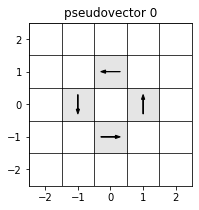

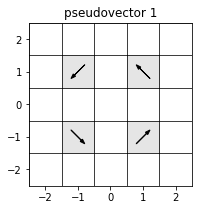

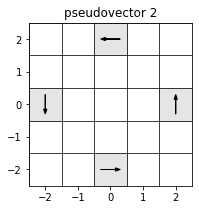

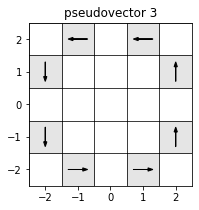

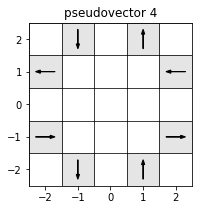

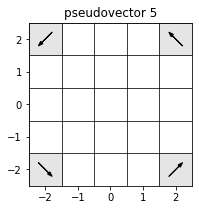

In [25]:
# Visualize (badly) the pseudovector filters.
for i, ff in enumerate(pvfilters):
    plot_vector_filter(ff, "pseudovector " + str(i))

# Proceed no further unless D=2!!

In [26]:
assert D == 2

In [27]:
!pip install finufft
import finufft

In [28]:
# make a sensible smooth scalar image on a 2-torus
N = 16
np.random.seed(42)
image = np.random.normal(size=(N, N))
foo = np.pi * np.arange(-1. + 1. / N, 1., 2. / N)
ys, xs = np.meshgrid(foo, foo) # ys, xs or xs, ys??
ft = finufft.nufft2d1(xs.flatten(), ys.flatten(), image.flatten().astype(complex), (3, 3))
scalar_image = finufft.nufft2d2(xs.flatten(), ys.flatten(), ft).reshape(N, N).real
scalar_image /= np.sqrt(np.mean(scalar_image ** 2))
print(scalar_image.shape, ft.shape)

(16, 16) (3, 3)


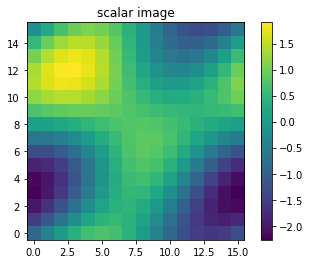

In [29]:
plt.imshow(scalar_image, interpolation="nearest", origin="lower")
plt.title("scalar image")
plt.colorbar()

In [30]:
# Make a sensible smooth vector image on a 2-torus
np.random.seed(42)
imagex = np.random.normal(size=(N, N))
imagey = np.random.normal(size=(N, N))
ftx = finufft.nufft2d1(xs.flatten(), ys.flatten(), imagex.flatten().astype(complex), (3, 3))
fty = finufft.nufft2d1(xs.flatten(), ys.flatten(), imagey.flatten().astype(complex), (3, 3))
vector_image = np.zeros((N, N, 2))
vector_image[:, :, 0] = finufft.nufft2d2(xs.flatten(), ys.flatten(), ftx).reshape(N, N).real
vector_image[:, :, 1] = finufft.nufft2d2(xs.flatten(), ys.flatten(), fty).reshape(N, N).real
vector_image /= np.sqrt(np.mean(vector_image ** 2))
print(vector_image.shape, ftx.shape)

(16, 16, 2) (3, 3)


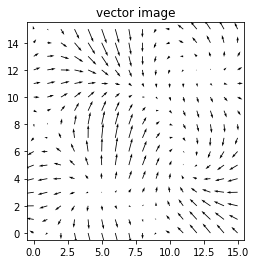

In [31]:
pxs, pys = np.meshgrid(np.arange(N), np.arange(N))
plt.gca().set_aspect("equal", adjustable="box")
plt.quiver(pxs.flatten(), pys.flatten(),
           vector_image[:, :, 0].flatten(), vector_image[:, :, 1].flatten())
plt.xlim(-0.5, N-0.5)
plt.ylim(-0.5, N-0.5)
plt.title("vector image")
plt.show()

In [32]:
# Make 2-torus convolution operator

def convolve_2d_torus(image, filter):
    """
    Warning: This code is stupid and brittle and dumb.
    """
    # check all inputs
    assert D == 2
    Ny, Nx = image.shape[:2]
    k = len(image.shape) - 2
    M = np.round(np.sqrt(len(filter))).astype(int)
    assert len(filter) == M * M
    assert M % 2 == 1
    # reformat filter into a block
    pad = (M - 1) // 2
    if len(np.atleast_1d(filter[keys[0]])) == 1:
        kprime = 0
    else:
        kprime = len(filter[keys[0]].shape)
    filtershape = (M, M)
    for foo in range(kprime):
        filtershape += (D, )
    ff = np.zeros(filtershape)
    for pp, kk in zip(pixels, keys):
        ff[pp[1] + pad, pp[0] + pad] = filter[kk]
    # kprime = SOMETHING
    # pad out the image with copies
    bigshape = [1 * foo for foo in image.shape]
    bigshape[0] += 2 * pad
    bigshape[1] += 2 * pad
    bigimage = np.zeros(bigshape)
    bigimage[pad:pad+Nx, pad:pad+Ny] = image
    bigimage[:pad, pad:pad+Nx] = image[-pad:]
    bigimage[-pad:, pad:pad+Nx] = image[:pad]
    bigimage[pad:pad+Ny, :pad] = image[:, -pad:]
    bigimage[pad:pad+Ny, -pad:] = image[:, :pad]
    bigimage[:pad, :pad] = image[-pad:, -pad:]
    bigimage[-pad:, :pad] = image[:pad, -pad:]
    bigimage[:pad, -pad:] = image[-pad:, :pad]
    bigimage[-pad:, -pad:] = image[:pad, :pad]
    # make output array
    outshape = image.shape + filtershape[2:]
    outimage = np.zeros(outshape)
    # reshape everyting and do the convolves
    ff = ff.reshape((M, M, D ** kprime))
    bigimage = bigimage.reshape((Ny + 2 * pad, Nx + 2 * pad, D ** k))
    outimage = outimage.reshape(Ny, Nx, D ** (k + kprime))
    for i in range(D ** k):
        for j in range(D ** kprime):
            # BUG: THIS NEXT LINE MUST BE WRONG!!
            outimage[:, :, i * D ** kprime + j] = sig.correlate2d(bigimage[:, :, i], ff[:, :, j], mode="valid")
    return outimage.reshape(outshape)

In [33]:
# Now plot convlutions of images with filters
# - for example: "(scalar image) \star (pseudovector 0)"
sstarv = convolve_2d_torus(scalar_image, vfilters[1])
sstars = convolve_2d_torus(scalar_image, filters[0])
vstars = convolve_2d_torus(vector_image, filters[0])
vstarv = convolve_2d_torus(vector_image, vfilters[1])
vstarpv = convolve_2d_torus(vector_image, pvfilters[1])

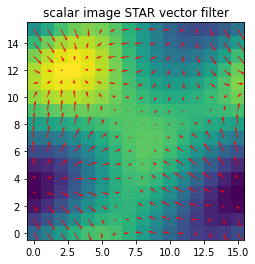

In [34]:
plt.gca().set_aspect("equal", adjustable="box")
plt.imshow(scalar_image, origin="lower")
plt.quiver(pxs.flatten(), pys.flatten(),
           sstarv[:, :, 0].flatten(), sstarv[:, :, 1].flatten(),
           color="r")
plt.xlim(-0.5, N-0.5)
plt.ylim(-0.5, N-0.5)
plt.title("scalar image STAR vector filter")
plt.show()

Text(0.5, 1.0, 'squared norm of the above vectors')

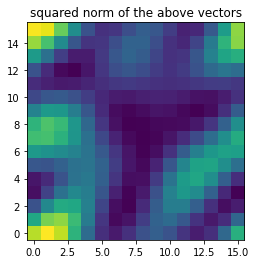

In [35]:
# Now show a nonlinear, local, scalar function of the scalar image
plt.imshow(np.sum(sstarv * sstarv, axis=-1), origin="lower")
plt.title("squared norm of the above vectors")

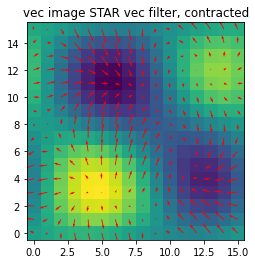

In [36]:
plt.gca().set_aspect("equal", adjustable="box")
plt.imshow(vstarv[:, :, 0, 0] + vstarv[:, :, 1, 1], origin="lower")
plt.quiver(pxs.flatten(), pys.flatten(),
           vector_image[:, :, 0].flatten(), vector_image[:, :, 1].flatten(),
           color="r")
plt.xlim(-0.5, N-0.5)
plt.ylim(-0.5, N-0.5)
plt.title("vec image STAR vec filter, contracted")
plt.show()

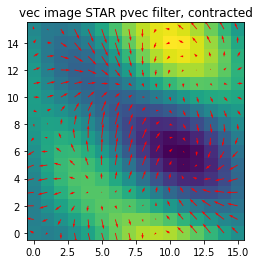

In [37]:
plt.gca().set_aspect("equal", adjustable="box")
plt.imshow(vstarpv[:, :, 0, 0] + vstarpv[:, :, 1, 1], origin="lower")
plt.quiver(pxs.flatten(), pys.flatten(),
           vector_image[:, :, 0].flatten(), vector_image[:, :, 1].flatten(),
           color="r")
plt.xlim(-0.5, N-0.5)
plt.ylim(-0.5, N-0.5)
plt.title("vec image STAR pvec filter, contracted")
plt.show()